### Introduction :-

Implementing the Particle Swarm Optimization Algorithm. The classes and other helper functions are implemented in the first section. The algorithm is as follows:
- Generate the initial population
- Calculate the fitness of the particles
- Perform while converges or number of generations:
    - Update the velocity and position of particles
    - Generate the new population
    - Calculate fitness of the new population
    - Update personal and global best
    - Update inertia factor

In [79]:
#CLASSES and OTHER HELPERS
'''
This section is responsible for implementing the classes and helper functions for Particle Swarm Optimization.
'''

# inbuilt dataset iris
from sklearn.datasets import load_iris
from sklearn import preprocessing as pp
from sklearn import utils
from sklearn import metrics
import numpy as np
import scipy
import matplotlib.pyplot as plt
import random

# This class is used to load the dataset from sklearn
class Dataset:
    def __init__(self):
        # Stores the data and target values for the dataset
        self.Y = None
        self.X = None

    # function to load and binarize the dataset for one-hot encodings
    def load_dataset(self):
        data = load_iris()

        # get the data and target from the data object
        self.X = np.array(data["data"])
        self.Y = np.array(data["target"])

        # Binarize the targets
        encoder = pp.LabelBinarizer()
        self.Y = encoder.fit_transform(self.Y)

    # function to shuffle the dataset
    def shuffle_dataset(self):
        # shuffle both the data and targets in unison
        self.X_shuffle, self.Y_shuffle = utils.shuffle(self.X, self.Y)

# Declaration of class PSO
class PSO:
    pass


# Class which represents the particles in the PSO algorithm. This class contains all the required for a particle.
'''
Variables included in the particle are:
- Fitness or Loss (inverse of each other)
- Dimension d (is the total number of weights in the network)
- Velocity
- Current Position
- Personal Best Position
'''
class Particle:

    # the high and low of the position
    high, low = 2.0, -2.0

    # constructor
    def __init__(self, d: int):
        # set the dimension
        self.d = d

        # set the loss as None, will be set when we run for training
        self.loss = None

        # Set velocity of dimension d and between 0 and 1
        self.vel = [np.random.rand() for i in range(d)]
        self.vel = np.array(self.vel)

        # Set current position to be random between -2.0 and 2.0
        self.currentPos = [random.uniform(self.low, self.high) for i in range(d)]
        self.currentPos = np.array(self.currentPos)

        # Personal best position is None.
        self.pBest: Particle = None

    # function to return the fitness/loss
    def get_loss(self):
        return self.loss

    # function update the position of a particle. For this we first update the velocity and then update the position using the new position.
    def update_position(self, obj: PSO):

        # If the global best is not found till yet
        if obj.gBest == None:
            print("Find Global Best First!")
            return

        # If the personal best is not found till now
        if self.pBest == None:
            print("Find Personal Best First!")
            return

        # Perform the updation
        '''
        1. Find two random numbers r1 and r2
        2. Update the velocity as:
            new_vel = w*pre_vel + c1*r1(currentPos - pBest) + c2*r2(currentPos - gBest)
        3. Update the position as:
            new_pos = old_pos + new_vel
        '''

        # 1.
        r1 = np.random.rand()
        r2 = np.random.rand()

        # 2.
        self.vel = PSO.w*np.array(self.vel) + PSO.c1*r1 * \
            np.array(-self.currentPos + self.pBest.currentPos) + PSO.c2 * \
            r2*np.array(-self.currentPos + obj.gBest.currentPos)

        # 3.
        self.currentPos = self.currentPos + self.vel

    # function to update the personal best
    def update_pBest(self):

        # personal best not yet found
        if self.pBest == None:
            self.pBest = self
            return

        # inverse relation in terms of loss
        if self.get_loss() < self.pBest.get_loss():
            self.pBest = self

    # function called when printing any particle

    def __str__(self):
        return f"{str(self.currentPos)}, {str(self.pBest)}"


'''
Class that represents the entire PSO algorithm (stores info for each generation). It contains:
- c1, c2 (2 and fixed)
- w (start from 0.9 and reduce by 0.03 till it reaches 0.4)
- particles (array containing all the particles for the algorithm)
- Global Best Solution Position
'''
class PSO:

    # value of cognitive and social component
    c1, c2 = 2, 2

    # initial value of inertia
    w = 0.9

    def __init__(self, pop_size: int):

        # set the population size
        self.pop_size = pop_size

        # set the particles array to none, will be assigned later
        self.particles: list(Particle) = None

        # Initially gBest is set to None
        self.gBest: Particle = None

    # function to reduce the inertia factor by a constant value
    def reduce_inertia(self):
        if PSO.w > 0.4:
            PSO.w = max(0.4, self.w - 0.03)

    # function to create the initial population
    def initial_population(self, d: int):

        # randomly create an array of size pop_size
        self.particles = [Particle(d) for i in range(self.pop_size)]

    # function to update the global best solution
    def update_gBest(self):

        # check each particle to find the best solution till now
        gbest_loss = 100.0
        for particle in self.particles:

            # since we are storing the loss, thus lesser the loss, the better solution
            if particle.get_loss() < gbest_loss:
                gbest_loss = particle.get_loss()
                self.gBest = particle


In [80]:
#import the header
import numpy as np
from sklearn import utils
from sklearn import metrics
import scipy

In [81]:
#Create the dataset object
dataset = Dataset()

#Load the dataset
dataset.load_dataset()

#Check if it is loaded
# print(dataset.X)
# print(dataset.Y.shape)

#Shuffle the dataset
dataset.shuffle_dataset()

In [82]:
#Model Params for the neural network
input_neurons = dataset.X.shape[1]

hidden_neurons = 4

output_neurons = dataset.Y.shape[1]

#dimension of the weight array
dimen = input_neurons * hidden_neurons + output_neurons * hidden_neurons + hidden_neurons + output_neurons


In [83]:
#Train() is used to train the fixed network. Takes as argument the params which contains the dictionary of weights and finds the loss (fitness) of the particle. Returns the loss of the particle. There is no back-propagation step in this. 

def Train(params:dict):

    #extract the weights and bias for the hidden layer
    wH = params["wH"]
    bH = params["bH"]
    
    #find output of the hidden layer
    zH = np.dot(wH, dataset.X_shuffle.T) + bH

    aH = np.maximum(zH, 0) #relu AF

    #extract weights and bias for the output layer
    wO = params["wO"]
    bO = params["bO"]

    #find output of the output layer
    zO = np.dot(wO, aH) + bO

    aO = scipy.special.softmax(zO) #softmax AF as multiple classes

    # calculate the loss
    loss = metrics.log_loss(dataset.Y_shuffle, aO.T)

    #return the loss for the particle
    return loss


In [84]:
#UnFlatten() is used to convert the weights obtained from particles from a 1D array to appropriate weight and bias matrices. Takes as argument the curren position or weight array of the particle and returns a dictionary containing the weights and biases matrices.

def UnFlatten(weights):
    params = dict()

    #unflatten the hidden layer weights
    wH = np.reshape(
        weights[0: (input_neurons * hidden_neurons)],
        (hidden_neurons, input_neurons),
    )

    #unflatten the output layer weights
    wO = np.reshape(
        weights[
            (input_neurons * hidden_neurons): (
                input_neurons * hidden_neurons + output_neurons * hidden_neurons
            )
        ],
        (output_neurons, hidden_neurons),
    )

    #unflatten the hidden layer biases
    bH = np.reshape(
        weights[
            (input_neurons * hidden_neurons + output_neurons * hidden_neurons): (
                input_neurons * hidden_neurons
                + output_neurons * hidden_neurons
                + hidden_neurons
            )
        ],
        (hidden_neurons, 1),
    )

    #unflatten the output layer biases
    bO = np.reshape(
        weights[
            (
                input_neurons * hidden_neurons
                + output_neurons * hidden_neurons
                + hidden_neurons
            ):
        ],
        (output_neurons, 1),
    )
    params = {"wH": wH, "wO": wO, "bH": bH, "bO": bO}

    return params

In [85]:
import matplotlib.pyplot as plt

#------------------- MAIN ----------------------
#This is the main alogrithm that combines all the components and carries out the process of PSO with the help of defined functions and header files.

def main(iter: int):
    #number of generations
    num_gen = 100

    #population size
    pop_size = 20

    #Create the base PSO object
    pso = PSO(pop_size)

    #Create the initial population
    pso.initial_population(dimen)

    #stores the min loss for each generation
    min_loss = [100.0 for i in range(num_gen)]

    #run a loop for the number of generations
    for i in range(num_gen):
        #Repeat for each particle
        for j in range(pop_size):

            #unflatten the weights and biases
            params = UnFlatten(pso.particles[j].currentPos)

            #train the network
            loss = Train(params)

            #update the min loss
            min_loss[i] = min(loss, min_loss[i])

            #Set the loss for this particle
            pso.particles[j].loss = loss

            #print the particle
            # print(pso.particles[j])
        
        #Update the global best
        pso.update_gBest()

        #Update the particles
        for j in range(pop_size):
            #update personal best if applicable
            pso.particles[j].update_pBest()

            #update the position of the particle
            pso.particles[j].update_position(pso)

        #After each generation, reduce the inertia
        pso.reduce_inertia()

    plt.title("Iteration Number {}".format(iter))
    plt.xlabel("Generations")
    plt.ylabel("Loss")
    plt.plot(min_loss)
    plt.legend(["Loss"])
    plt.show()

    #return the min loss for the generation
    return np.min(min_loss)


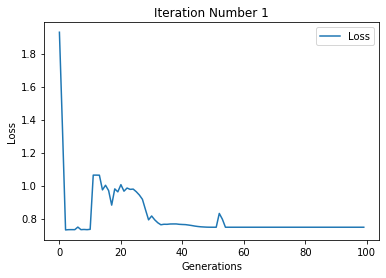

Min Loss for Iteration 1 = 0.7308494962026113



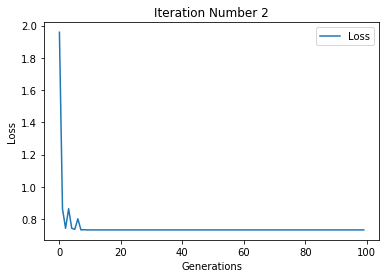

Min Loss for Iteration 2 = 0.7324081937999639



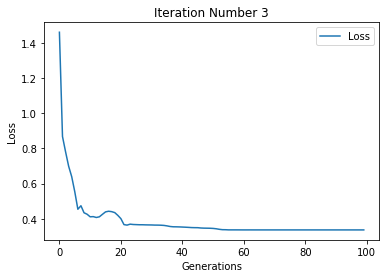

Min Loss for Iteration 3 = 0.33627533331691134



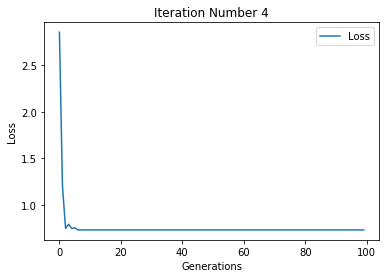

Min Loss for Iteration 4 = 0.7324081931743112



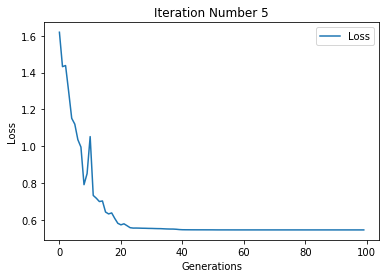

Min Loss for Iteration 5 = 0.5450459350020274



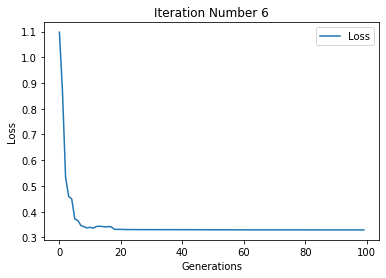

Min Loss for Iteration 6 = 0.32918206894020197



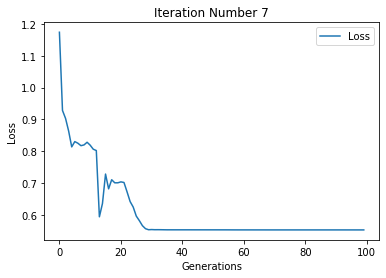

Min Loss for Iteration 7 = 0.5530161505158411



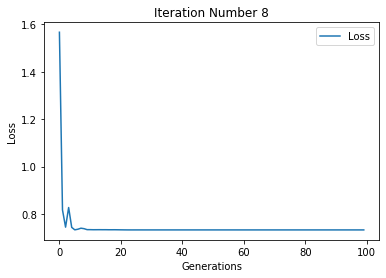

Min Loss for Iteration 8 = 0.7324483498374388



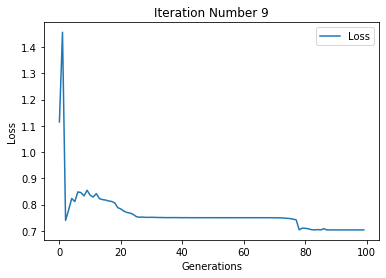

Min Loss for Iteration 9 = 0.7035614803936657



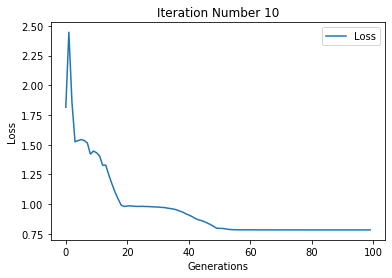

Min Loss for Iteration 10 = 0.7817751034243214



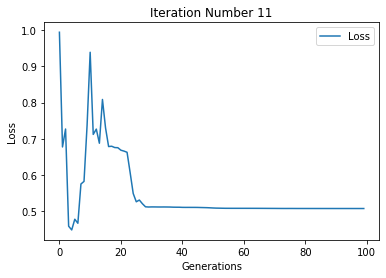

Min Loss for Iteration 11 = 0.4490491831700436



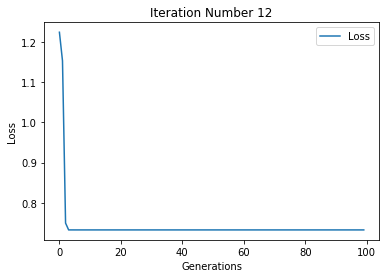

Min Loss for Iteration 12 = 0.7324081925062501



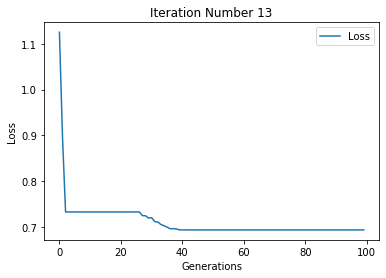

Min Loss for Iteration 13 = 0.6931471811504857



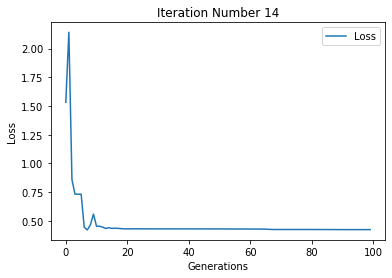

Min Loss for Iteration 14 = 0.42156477765860567



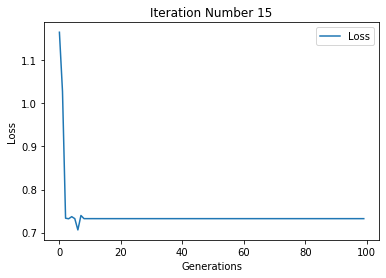

Min Loss for Iteration 15 = 0.7062653980643623



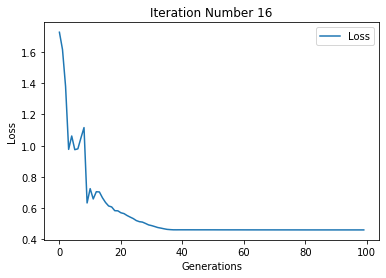

Min Loss for Iteration 16 = 0.4603810673994603



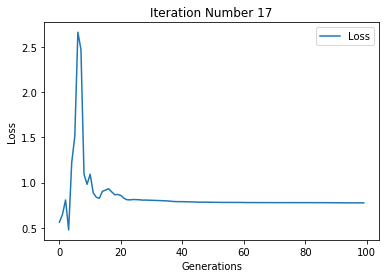

Min Loss for Iteration 17 = 0.4769536767311205



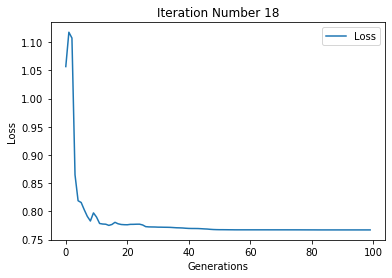

Min Loss for Iteration 18 = 0.7671048640961281



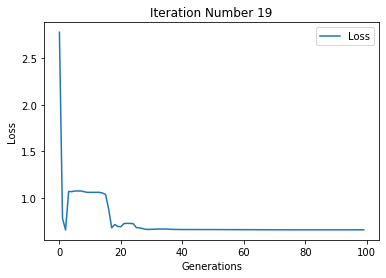

Min Loss for Iteration 19 = 0.6598235424700979



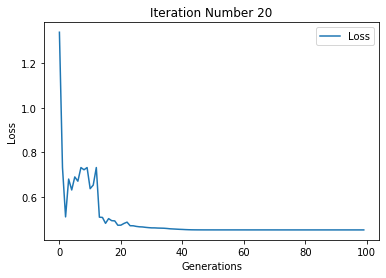

Min Loss for Iteration 20 = 0.4533718810908015



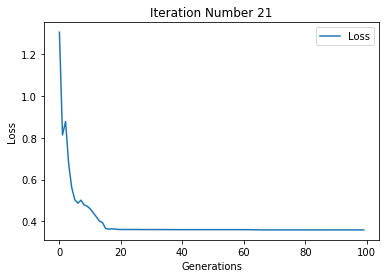

Min Loss for Iteration 21 = 0.3594517927158554



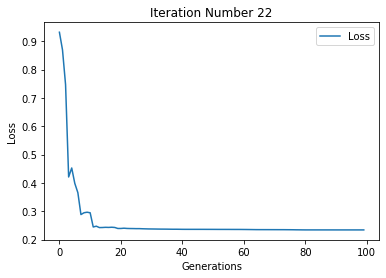

Min Loss for Iteration 22 = 0.23425149650082158



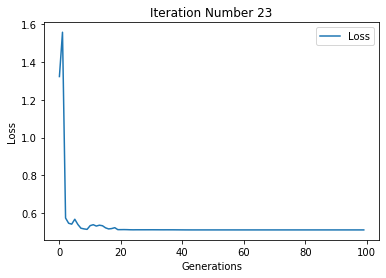

Min Loss for Iteration 23 = 0.5110760504651336



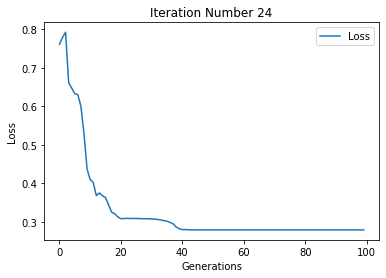

Min Loss for Iteration 24 = 0.2789813027388993



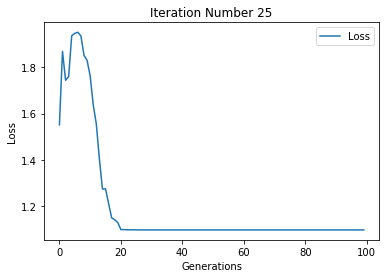

Min Loss for Iteration 25 = 1.0986122886681093



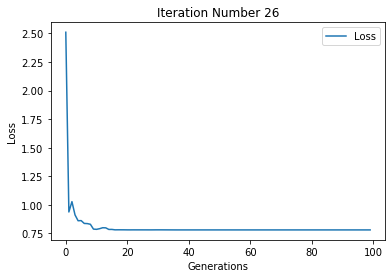

Min Loss for Iteration 26 = 0.7799665738178179



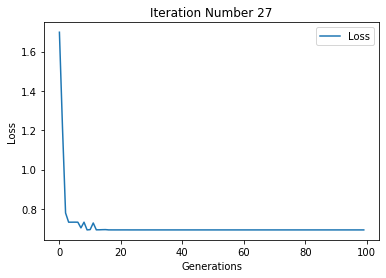

Min Loss for Iteration 27 = 0.6931472519701132



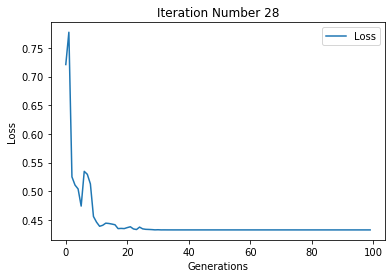

Min Loss for Iteration 28 = 0.4323908832013663



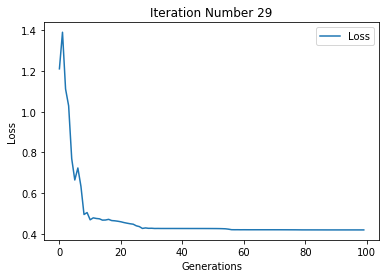

Min Loss for Iteration 29 = 0.41844423201120756



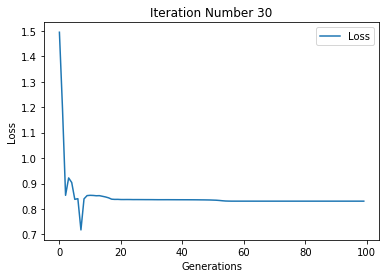

Min Loss for Iteration 30 = 0.7176343139834118



In [86]:
#Repeat the PSO for 30 iterations to get the best result

#number of iterations
num_iterations = 30

for i in range(num_iterations):
    loss = main(i + 1)

    print("Min Loss for Iteration {} = {}".format(i  + 1, loss))
    print()